In [1]:
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import mpu

from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

/home/milan/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def getPercentileBinnedDistribution(x, y, nbins):

    x, y = zip(*sorted(zip(x, y), key=lambda tup: tup[0]))
    elements_per_bin = int(len(x)/float(nbins))

    xx  = [np.mean(x[i*elements_per_bin:(i+1)*elements_per_bin]) for i in range(nbins)]
    yy  = [np.mean(y[i*elements_per_bin:(i+1)*elements_per_bin]) for i in range(nbins)]
    std = [np.std(y[i*elements_per_bin:(i+1)*elements_per_bin])  for i in range(nbins)]

    return xx, yy, std

### Get success targets

In [3]:
city        = 'london'
outfolder   = '../ProcessedData/' + city + '/'
successdata = outfolder + 'venues_info/' + city + '_venues_success_measures.csv'
success     = pd.read_csv(successdata, sep = '\t', index_col = 0)
success     = success[~success.index.duplicated(keep='first')]   

successdata_L = outfolder + 'venues_info/' + city + '_venues_success_measures_local_like.csv'
success_L     = pd.read_csv(successdata_L, sep = '\t', index_col = 0)
success_L     = success_L[~success_L.index.duplicated(keep='first')]   

len(success), len(success_L)




,Llikecount
51e72fb78bbd22a2ac38a4d5,1.443167
4bd5c35e29eb9c74b9dc93e1,1.889869
53de1ee1498e6c335b1ac6c4,2.435633
4e4cdd6e18a822288dd7706a,0.471928
56753a5f498ecd2d67eab4c6,1.071919


In [4]:
success.head()

,tipCount,checkinsCount,usersCount
4a5f9446f964a520e0bf1fe3,75.0,2500.0,1831.0
4abcec53f964a520b98720e3,17.0,1550.0,913.0
4abdc1c7f964a5206d8b20e3,47.0,5573.0,2777.0
4abe4502f964a520558c20e3,575.0,97190.0,80793.0
4abe5714f964a520d68c20e3,54.0,1507.0,1256.0


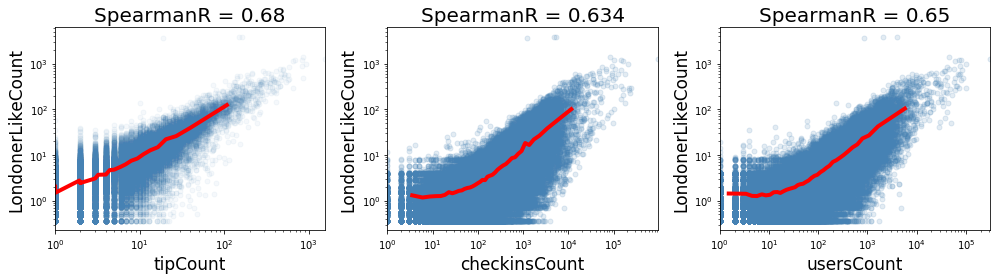

In [50]:
success2 = success.join(success_L)
success2 = success2.dropna()
success2 = success2[(success2.T != 0).any()]

f, ax = plt.subplots(1, 3, figsize=(14, 4))

ax[0].plot(success2['tipCount'], success2['Llikecount'], 'o', color = 'steelblue', markersize = 5, alpha = 0.05)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('tipCount', fontsize = 17)
ax[0].set_ylabel('LondonerLikeCount', fontsize = 17)
ax[0].set_title('SpearmanR = ' + str(round(spearmanr(success2.tipCount, success2.Llikecount)[0], 3)), fontsize = 20)

bx, by, err = getPercentileBinnedDistribution(success2.tipCount, success2.Llikecount, 40)
ax[0].plot(bx[1:], by[1:], linewidth = 4, color = 'r')
ax[0].set_xlim([1, max(success2.tipCount)])





ax[1].plot(success2['checkinsCount'], success2['Llikecount'], 'o', color = 'steelblue', markersize = 5, alpha = 0.15)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('checkinsCount', fontsize = 17)
ax[1].set_ylabel('LondonerLikeCount', fontsize = 17)
ax[1].set_title('SpearmanR = ' + str(round(spearmanr(success2.checkinsCount, success2.Llikecount)[0], 3)), fontsize = 20)

bx, by, err = getPercentileBinnedDistribution(success2.checkinsCount, success2.Llikecount, 40)
ax[1].plot(bx[1:], by[1:], linewidth = 4, color = 'r')
ax[1].set_xlim([1, max(success2.checkinsCount)])



ax[2].plot(success2['usersCount'], success2['Llikecount'], 'o', color = 'steelblue', markersize = 5, alpha = 0.15)
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel('usersCount', fontsize = 17)
ax[2].set_ylabel('LondonerLikeCount', fontsize = 17)
ax[2].set_title('SpearmanR = ' + str(round(spearmanr(success2.usersCount, success2.Llikecount)[0], 3)), fontsize = 20)

bx, by, err = getPercentileBinnedDistribution(success2.usersCount, success2.Llikecount, 40)
ax[2].plot(bx[1:], by[1:], linewidth = 4, color = 'r')
ax[2].set_xlim([1, max(success2.usersCount)])



plt.tight_layout()



In [4]:
# RANDOMIZE HERE
# np.random.shuffle(success.checkinsCount)
success['quartile'] = pd.qcut(success['checkinsCount'], 4, ['q1','q2','q3','q4'])
Q1 = list(success[success['quartile'] == 'q1'].index)
Q4 = list(success[success['quartile'] == 'q4'].index)

### Get success features

In [25]:
def get_centroids(c):
     return (sum(c[0])/len(c[0]),sum(c[1])/len(c[1]))

def encode_cats(df, column):
    le = preprocessing.LabelEncoder()
    le.fit(df[column])
    df[column] = le.transform(df[column])    
    return df

In [27]:
nc_threshold = 5000

# get the yelp money things
# ward_yelp_money    = outfolder + 'venues_info/london_price_wards_yelp.csv'
# ward_money         = pd.read_csv(ward_yelp_money, sep = ',', index_col = 0)#.drop(['ward'], axis=1)
# ward_money         = ward_money[~ward_money.index.duplicated(keep='first')] 
# ward_money         = ward_money.rename(index=str, columns={aa : 'yelp_' +  aa  for aa in ward_money.keys()})    
# ward_money['ward'] = ward_money.index


# basic stats of wards: bbox, length, area
# outfolder    = '../ProcessedData/' + city + '/'
# ward_stats_f = outfolder + 'venues_info/venues_ward_full.dat'
# ward_stats   = pd.read_csv(ward_stats_f, sep = '\t', index_col = 0)
# ward_stats   = ward_stats[~ward_stats.index.duplicated(keep='first')]   
# ward_stats   = pd.merge(ward_stats, ward_money, how='left', on='ward', right_index=True)
# ward_stats   = ward_stats.drop(['ward'], axis=1)


# get the distance from the center
#lngs = list(ward_stats.lng)
#lats = list(ward_stats.lat)
#london_lng, london_lat = get_centroids((lngs, lats))
#ward_stats['distance_from_center'] = ward_stats.apply(lambda row: mpu.haversine_distance((row.lat, row.lng ), (london_lat, london_lng)), axis=1)
#ward_stats.reset_index(inplace=True)

ward_stats_Q1 = ward_stats[ward_stats['venue'].isin(Q1)]
ward_stats_Q4 = ward_stats[ward_stats['venue'].isin(Q4)]

ward_stats_Q1 = ward_stats_Q1.set_index('venue')
ward_stats_Q4 = ward_stats_Q4.set_index('venue')


# category stats of wards: number of venues, fraction of food, nightlife..., entropy
# ward_cats_f  = outfolder + 'venues_info/' + city + '_WARD_category_stats.csv'
# ward_cats    = pd.read_csv(ward_cats_f, sep = '\t', index_col = 0).drop(['ward'], axis=1)
# ward_cats    = ward_cats[~ward_cats.index.duplicated(keep='first')]   
# ward_cats    = encode_cats(ward_cats, 'venue_cat')
# ward_cats    = encode_cats(ward_cats, 'venue_subcat')


ward_cats.reset_index(inplace=True)
ward_cats_Q1 = ward_cats[ward_cats['index'].isin(Q1)]
ward_cats_Q4 = ward_cats[ward_cats['index'].isin(Q4)]

ward_cats_Q1 = ward_cats_Q1.set_index('index')
ward_cats_Q4 = ward_cats_Q4.set_index('index')


# venue similarity network stuff with threshold (1000 for now) 
# and
# user friendship network measures aggregated on the venue level
network_meas_f  = outfolder + '/networks/' + city + '_COMBINED_networkmeasures_' + str(nc_threshold) + '.csv'
network_meas    = pd.read_csv(network_meas_f, sep = ',', index_col = 0).replace([np.inf, -np.inf], np.nan).fillna(0.0)
network_meas    = network_meas[~network_meas.index.duplicated(keep='first')]   

network_meas.reset_index(inplace=True)
network_meas_Q1 = network_meas[network_meas['index'].isin(Q1)]
network_meas_Q4 = network_meas[network_meas['index'].isin(Q4)]

network_meas_Q1 = network_meas_Q1.set_index('index')
network_meas_Q4 = network_meas_Q4.set_index('index')


#merging all features
temp_Q1 = network_meas_Q1.join(ward_cats_Q1)
venue_features_Q1 = temp_Q1.join(ward_stats_Q1)

temp_Q4 = network_meas_Q4.join(ward_cats_Q4)
venue_features_Q4 = temp_Q4.join(ward_stats_Q4)

venue_features_Q4.head()
ward_stats_Q4.head()

,lng,lat,lng0,lat0,lng1,lat1,length,area,yelp_biz_cnt,yelp_price_avg,yelp_price_median,distance_from_center
venue,,,,,,,,,,,,
4ed012c26c2510ace08f6196,-0.148227,51.506406,-0.158366,51.501861,-0.128997,51.520817,0.085100,0.000259,2603.0,2.339207,2.0,0.934851
4ea2aef30aaf711180b2f463,0.045362,51.563012,0.014182,51.554062,0.052812,51.585937,0.157319,0.000673,6.0,NaN,NaN,13.871446
50773130e4b0ce304488c1e8,-0.221241,51.534717,-0.226976,51.527928,-0.199326,51.542596,0.077941,0.000193,100.0,2.000000,2.0,6.605137
54f9d6b0498e414bb84d2455,0.021645,51.487262,-0.005555,51.481413,0.035078,51.506768,0.116350,0.000581,165.0,2.077778,2.0,11.126397
50a78ea8e4b0034096253c46,-0.113661,51.480741,-0.130662,51.477240,-0.104047,51.488295,0.079764,0.000165,141.0,1.911765,2.0,3.465833


Text(0,0.5,'Hist')

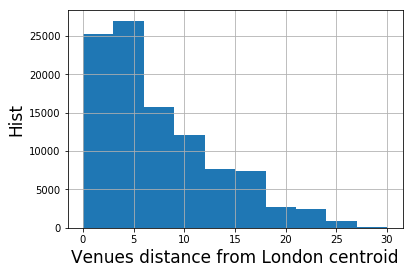

In [45]:
ward_stats['distance_from_center'].hist()
plt.xlabel('Venues distance from London centroid', fontsize = 17)
plt.ylabel('Hist', fontsize = 17)

Text(0,0.5,'Hist')

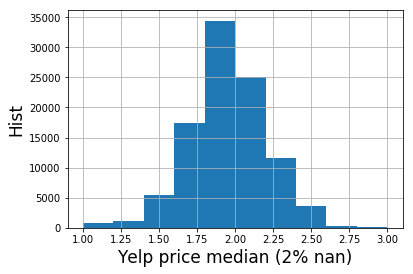

In [50]:
ward_stats.yelp_price_avg.hist()
plt.xlabel('Yelp price median (2% nan)', fontsize = 17)
plt.ylabel('Hist', fontsize = 17)

# Classification

In [5]:
# get the data
venue_features_Q1['successful'] = 0
venue_features_Q4['successful'] = 1

X_ = venue_features_Q4.append(venue_features_Q1).drop(columns = ['successful'])
X_ = X_.drop(columns = ['lng', 'lat'])

X_head = X_.keys()

X = pd.DataFrame()

#X= X_

for feat in X_head:
    #if  'v_' not in feat and 'u_' not in feat:
    X[feat] = X_[feat]


success = venue_features_Q4.append(venue_features_Q1)['successful']
y = np.asarray(success)


X_head = X.keys()
print len(X.keys())
print len(X)
print len(y)

X.head()


98
51002
51002


,u_pagerank_geo_avg,u_eigenvector_avg,u_pagerank_geo_std,u_degree_avg,u_closeness_entropy,u_degree_std,u_strength_geo_avg,u_pagerank_geo_entropy,u_closeness_std,u_betweenness_std,...,shops,arts_entertainment,event,parks_outdoors,lng0,lat0,lng1,lat1,length,area
index,,,,,,,,,,,,,,,,,,,,,
4abdc1c7f964a5206d8b20e3,4.881170e-07,0.000249,7.030505e-07,0.067669,0.998622,0.328942,0.976730,0.885992,1.013314e-06,5703.073122,...,0.183197,0.041424,0.003501,0.030922,-0.119896,51.518541,-0.100129,51.531899,0.062448,0.000121
4ac3ba25f964a520919c20e3,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.091275,0.063087,0.008054,0.045638,-0.130866,51.522967,-0.112949,51.530937,0.042583,0.000079
4ac518b4f964a52064a020e3,2.185284e-06,0.001537,4.041999e-06,0.783784,1.000000,2.472936,4.281519,0.767971,5.124951e-08,39109.211595,...,0.275067,0.069407,0.005521,0.012620,-0.158366,51.501861,-0.128997,51.520817,0.085100,0.000259
4ac518b4f964a52066a020e3,4.462280e-06,0.000555,2.499787e-06,1.636364,1.000000,2.143605,6.952557,0.934049,1.333181e-07,10108.403002,...,0.285562,0.103889,0.006393,0.018114,-0.179571,51.490820,-0.155319,51.502250,0.062966,0.000138
4ac518b4f964a52067a020e3,5.851412e-06,0.004192,8.728456e-06,2.571429,1.000000,5.394631,12.612710,0.725952,1.452973e-07,84316.049607,...,0.168011,0.084573,0.013990,0.043988,-0.151685,51.493703,-0.111102,51.516040,0.111045,0.000449


In [6]:
def classifiers(X, y):
   
    classifier = RandomForestClassifier(max_depth=5, n_estimators=10, max_features='auto') 
    # preprocess dataset, split into training and test part
    # X = StandardScaler().fit_transform(X)
    # X = preprocessing.quantile_transform(X, output_distribution = 'normal')
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=.33, random_state=42)
    
    # iterate over classifiers
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print 'CrossCalScore\t', score, np.mean(cross_val_score(classifier, X_train, y_train, cv=3))

        
classifiers(X, y)

CrossCalScore	0.500267363793001 0.497146883183218


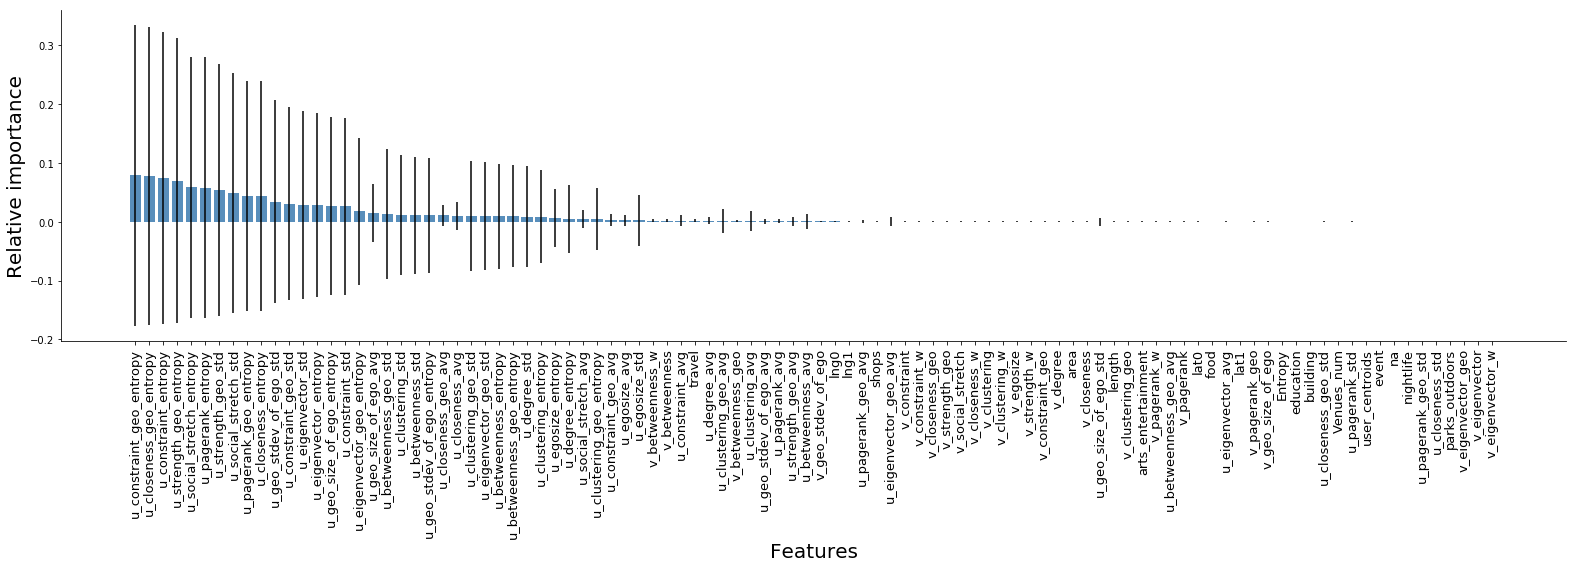

In [13]:
def importance(X, y):
   

    classifier = RandomForestClassifier(max_depth=5, n_estimators=1000, max_features='auto') 
    # preprocess dataset, split into training and test part
    # X = StandardScaler().fit_transform(X)
    # X = preprocessing.quantile_transform(X, output_distribution = 'normal')
    # X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=.8, random_state=42)
    
    # iterate over classifiers
    classifier.fit(X, y)
    
    importances = classifier.feature_importances_
    std         = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
    indices     = np.argsort(importances)[::-1]
    
    

    
    df = pd.DataFrame()

   # df['ind'] = [X_head[i] for i in indices]
   # df['val'] = [importances[i] for i in indices if importances[i]]
    
    #df['ind'], df['val'], xlabels = zip(*[(X_head[i], importances[i], X_head[i]) for i in indices if i < 11])
    df['ind'], df['val'], xlabels = zip(*[(X_head[i], importances[i], X_head[i]) for i in indices])# if i < 11])

    
    df    = df.sort_values(['val'], ascending = False)
    f, ax = plt.subplots(1, 1, figsize=(22, 8))
    
    #ax.set_xticklabels([X_head[i] for i in indices], rotation = 90)
    '''ax.barh(range(X.shape[1]), importances[indices], color="b", xerr=std[indices], align="center")
    
    
    ax.set_yticklabels(xlabels, rotation = 0, fontsize = 16)
    '''
    
    #sns.barplot(y="val", x="ind", data=df, ax = ax)
    
    ax.bar(range(X.shape[1]), importances[indices], color="steelblue", alpha = 0.9,yerr=std[indices], align="center")

    ax.set_xticks(sorted(indices))
    ax.set_xticklabels(xlabels, rotation = 90, fontsize = 13)
   # ax.set_yticks([0.01, 0.02, 0.03, 0.04, 0.05])
   # ax.set_yticklabels(['1%', '2%', '3%', '4%', '5%'], fontsize = 16)
    ax.set_ylabel('Relative importance', fontsize = 20)
    ax.set_xlabel('Features', fontsize = 20)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
 
    #score = classifier.score(X_test, y_test)
    #print 'CrossCalScore\t', score, np.mean(cross_val_score(classifier, X_train, y_train, cv=10))
 
        
importance(X, y)




# FEATURE IMPORTANCE

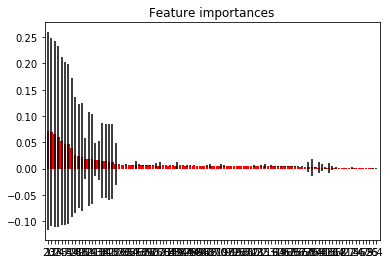

In [8]:
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
from sklearn.ensemble import ExtraTreesClassifier



# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250, random_state=42)

forest.fit(X, y)
importances = forest.feature_importances_
std         = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
#plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")

plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()


In [ ]:

f, ax = plt.subplots(1, 1, figsize=(21, 8))
#ax.bar(range(X.shape[1]), importances[indices], color="r", align="center", alpha = 0.79)
ax.bar(range(X.shape[1])[0:18], importances[indices][0:18], color="b", align="center", alpha = 0.79)
ax.bar(range(X.shape[1])[18:], importances[indices][18:], color="b", align="center", alpha = 0.33)
ax.set_xticks(sorted(indices))
ax.set_xticklabels([X_head[i] for i in indices], rotation = 90)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('../../Pres/importance.png')
#indices#, indices



In [ ]:
df = pd.DataFrame()
df['ind'] = [X_head[i] for i in indices]
df['val'] = [importances[i] for i in indices]
df        = df.sort_values(['val'], ascending = False)

f, ax = plt.subplots(1, 1, figsize=(21, 8))

sns.barplot(x="ind", y="val", data=df, ax = ax)

ax.set_xticks(sorted(indices))
ax.set_xticklabels([X_head[i] for i in indices], rotation = 90, fontsize = 12)

ax.set_yticks([0.01, 0.02, 0.03, 0.04, 0.05])
ax.set_yticklabels(['1%', '2%', '3%', '4%', '5%'], fontsize = 16)
ax.set_ylabel('Relative importance', fontsize = 20)
ax.set_xlabel('Features', fontsize = 20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('../../Pres/importance.png')



In [ ]:
plt.hist(importances, bins = 20)

In [ ]:
feat_imp = [(X_head[ind], imp) for ind, imp in enumerate(importances)]
feat_imp_sorted = sorted(feat_imp, key=lambda tup: tup[1], reverse = True)

ok_feats = []

for (feat, imp) in feat_imp_sorted:
    #print feat, '\t' , round(imp,3)
    if imp > 0.03:
        ok_feats.append(feat)
    
print ok_feats
    

In [ ]:
all_features   = [i[0] for i in feat_imp_sorted ]
top8_features  = [i[0] for i in feat_imp_sorted[0:8] ]
top12_features = [i[0] for i in feat_imp_sorted[0:12] ]

In [ ]:
all_features

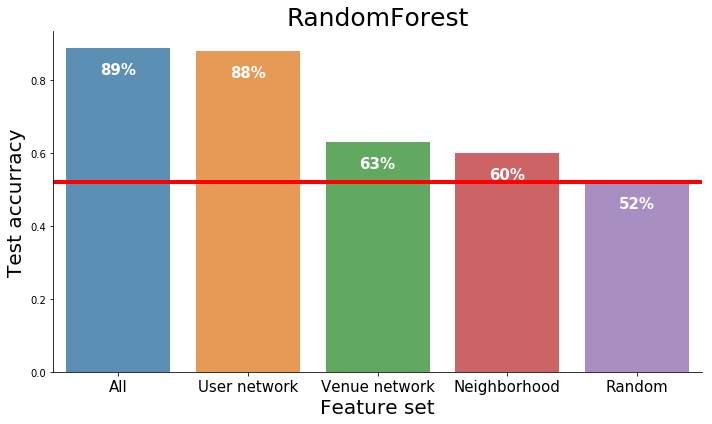

In [100]:
%matplotlib inline
df = pd.DataFrame()
df['ind'] = ['All','User network', 'Venue network', 'Neighborhood', 'Random']
df['val'] = [0.89, 0.88, 0.63, 0.60, 0.52]
df        = df.sort_values(['val'], ascending = False)


f, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.barplot(x="ind", y="val", data=df, ax = ax, alpha = 0.8, capsize=.2 )
ax.set_ylabel('Test accurracy', fontsize = 20)
ax.set_xlabel('Feature set', fontsize = 20)
ax.set_xticklabels(df['ind'], fontsize = 15)
#ax.set_yticklabels(['0%', '10%','20%','30%','40%', '50%', '60%'], fontsize = 15)

ax.axhline(y = 0.52, linewidth=4, color='r')
ax.set_title('RandomForest', fontsize = 25)
rects = ax.patches

for rect, label in zip(rects, df['val']):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height-0.08 , str(100*label).replace('.0','') + '%',ha='center', weight = 'bold', va='bottom', color = 'white', fontsize = 15)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('../../Pres/barplot.png')
plt.show()

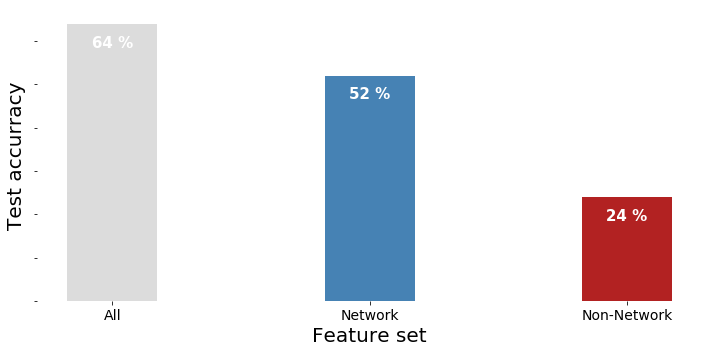

In [33]:
from matplotlib.ticker import FuncFormatter

x = ['All','Network','Non-Network']
y = [0.64, 0.52, 0.24]

def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x * 1e-6)


formatter = FuncFormatter(millions)

f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel('Test accurracy', fontsize = 20)
ax.set_xlabel('Feature set',    fontsize = 20)
ax.set_xticklabels(df['ind'], fontsize = 14)
ax.set_yticklabels(['0%', '10%','20%','30%','40%', '50%', '60%'], fontsize = 14)
ax.set_yticklabels(['', '','','','', '', ''], fontsize = 14)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


plt.tight_layout()

labels = [str(10*yy).replace('.','') + ' %' for yy in y]


ax.bar(x, y, width = 0.35, color = 'steelblue')



y = [0.64, 0.0, 0.0]
ax.bar(x, y, width = 0.35, color = 'gainsboro')






x = ['All','Network','Non-Network']
y = [0, 0, 0.24]
ax.bar(x, y, width = 0.35, color = 'firebrick')


rects = ax.patches


for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height - 0.06 , label,ha='center', weight = 'bold', va='bottom', color = 'white', fontsize = 15)

#plt.xticks(x, ('Bill', 'Fred', 'Mary', 'Sue'))
#plt.savefig('../../Pres/barplot.png')

plt.show()

In [ ]:
wards_checkins = {}

for ind, line in enumerate(open(ward_cats_f)):
    #if ind == 10: break
    if 'Venues_' not in line:
        venue, b, e, f, na, t, Venues_num, u, E, n, s, a, ward, e, p = line.strip().split('\t')
        chk = success.loc[venue]['checkinsCount']
        if chk > 0:
            if ward not in wards_checkins:
                wards_checkins[ward] = [chk]
            else:
                wards_checkins[ward].append(chk)

print len(wards_checkins)
    

In [ ]:

def getDistribution(keys, normalized = True):
    
    uniq_keys = np.unique(keys)
    bins = uniq_keys.searchsorted(keys)
    distr = np.bincount(bins) 

    if normalized == 1: distr = distr/float(np.sum(distr)) 

    return np.asarray(uniq_keys.tolist()), np.asarray(distr.tolist())




In [ ]:
def getLogBinnedDistribution(x, y, nbins):

    bins   = 10 ** np.linspace(np.log10(min(x)), np.log10(max(x)), nbins)  
    
    values = [ np.mean([y[j]  for j in range(len(x)) if x[j] >= bins[i] and x[j] < bins[i+1]])  for i in range(nbins-1)]    
    error  = [ np.std( [y[j]  for j in range(len(x)) if x[j] >= bins[i] and x[j] < bins[i+1]])  for i in range(nbins-1)]
    bins   = (bins[1:] + bins[:-1])/2

    #print bins
    return bins, values, error



f, ax = plt.subplots(1, 1, figsize=(21, 8))

for w, ch in wards_checkins.items():
    if len(ch) > 1000:
        
        x, y = getDistribution(ch)
        bx, by, yerr =   getLogBinnedDistribution(x,y, 10)
        ax.plot(bx,by, 'o-', markersize = 8, label = ward + ',  ' + str(len(ch)))
        
plt.legend(loc='best')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of CheckIns', fontsize = 18)
ax.set_ylabel('binned pdf', fontsize = 18)
ax.set_title('#Checkin distribution in the largest wards',  fontsize = 24)